# SPDR Sector ETF Analysis

This notebook will essentially be a continuation of the previous notebook that tracked the performance of market indexes qualitatively over different time horizons. This notebook will still address the same time horizons, however because these ETFs represent more specific sectors of the stock market, their performances may diverge from the behavior observed and modeled in the previous notebook.

In [253]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.dummy import DummyClassifier 
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, recall_score, precision_score, f1_score, \
log_loss, auc, roc_auc_score, roc_curve, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingRegressor, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost
from xgboost import XGBClassifier
# from imblearn.over_sampling import SMOTE

import datetime as dt

# New import of my custom class
from classification_classes import Model
from spider_classes import Materials, Energy, Financials, Industrials, Technology, Staples, Utilities, Health, \
Consumer, Real_Estate, Communication_Services

pd.set_option("display.max_rows", 25)
pd.set_option('display.max_columns', 35)
sns.set_style("dark")

In [107]:
import warnings

# Suppress FutureWarnings for all of scikit-learn's modules
warnings.filterwarnings("ignore")

### New container for feature importances

In [195]:
# Class for collecting coefficients of models based on economic features

class Importance():
    df = pd.DataFrame(columns=['Interest Rates', 'GDP', 'ATR', 'lowest_bollinger_band', 'MACD', \
                                    'lower_bollinger_band', 'upper_bollinger_band', '20_day_SMA', \
                                    'one_up_bollinger_band', 'Close', 'High', 'Adj Close', 'Low', 'RSI', \
                                    'Open', 'dollar_volume(M)', 'Volume', 'garman_klass_vol', 'SMB', 'CMA', 'HML',\
                                    'RMW', 'Mkt-RF', 'Quarter_1', 'Quarter_2', 'Quarter_3', 'Quarter_4', \
                              'cycle_year_1', 'cycle_year_2', 'cycle_year_3', 'cycle_year_4'])
    
    # Init method
    def __init__(self, coefs):
        self.dict = coefs
    
        # Add the metrics to the class dataframe
        idx = len(Importance.df)
        Importance.df.loc[idx] = self.dict
    
    
    def add_coefs(self, coefs):
        idx = len(Importance.df)
        Importance.df.loc[idx] = coefs
        
    
    def __str__(self):
      return "Feature Importance/Coefficient DataFrame"
        

<hr style="border: 3px solid black">

# SPDR Data

The term "SPDR" stands for "Standard & Poor's Depositary Receipts." These ETFs were literally the first Exchange Traded Funds offered to the public markets that allowed investors to gain access to large sectors of the market or entire indices depending on your preference. As the previous notebook analyzed the major market indices, this notebook will focus on the sector indices to provide a different perspective. The process for modeling will be largely the same. Because so many of the models from the previous notebook performed so well without overfitting, I did not tune them using GridsearchCV. Depending on performances in this notebook, there may be more tuning.

In [109]:
# Loading the data

df = pd.read_csv("./Files/Spiders_Final.csv")
print(df.shape)
df.head()

(59633, 33)


,Date,Ticker,Adj Close,Close,High,Low,Open,Volume,garman_klass_vol,RSI,lowest_bollinger_band,lower_bollinger_band,20_day_SMA,one_up_bollinger_band,upper_bollinger_band,ATR,MACD,dollar_volume(M),GDP,Interest Rates,Mkt-RF,SMB,HML,RMW,CMA,one_months_later,three_months_later,six_months_later,twelve_months_later,One_Month_Positive,Three_Month_Positive,Six_Month_Positive,Twelve_Month_Positive
0,1998-12-22,XLB,12.011767,20.828125,20.828125,20.750000,20.781250,1900.0,-0.116068,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0228,9293.991,0.0439,0.0,-0.0029,-0.0043,-0.0009,0.0078,1999-01-22,1999-03-22,1999-06-22,1999-12-22,1.0,1.0,1.0,1.0
1,1998-12-22,XLE,12.448157,23.265625,23.390625,23.187500,23.312500,15200.0,-0.152028,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.1892,9293.991,0.0439,0.0,-0.0029,-0.0043,-0.0009,0.0078,1999-01-22,1999-03-22,1999-06-22,1999-12-22,0.0,1.0,1.0,1.0
2,1998-12-22,XLF,11.612926,18.937855,19.052092,18.849005,19.052092,55887.0,-0.094617,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.6490,9293.991,0.0439,0.0,-0.0029,-0.0043,-0.0009,0.0078,1999-01-22,1999-03-22,1999-06-22,1999-12-22,0.0,1.0,1.0,1.0
3,1998-12-22,XLI,14.971390,23.281250,23.281250,23.203125,23.203125,600.0,-0.074152,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0090,9293.991,0.0439,0.0,-0.0029,-0.0043,-0.0009,0.0078,1999-01-22,1999-03-22,1999-06-22,1999-12-22,1.0,1.0,1.0,1.0
4,1998-12-22,XLK,24.243126,32.046875,32.500000,31.781250,32.406250,300500.0,-0.032286,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.2851,9293.991,0.0439,0.0,-0.0029,-0.0043,-0.0009,0.0078,1999-01-22,1999-03-22,1999-06-22,1999-12-22,1.0,1.0,1.0,1.0


In [110]:
# Feature Transformations and additions

df["Date"] = pd.to_datetime(df["Date"])
df["Quarter"] = df["Date"].dt.quarter.astype(str)
df["cycle_year"] = (df["Date"].dt.year % 4)
df['cycle_year'] = df['cycle_year'].apply(lambda x: 4 if x == 0 else x).astype(str)
df.set_index("Date", inplace=True)

In [111]:
df.shape

(59633, 34)

In [112]:
df.dropna(inplace=True)
df.shape

(56597, 34)

In [113]:
# Cell creates a dataframe of the NORMALIZED value counts for each ETF and each time target

tickers = ['XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY',
       'XLRE', 'XLC']

# Value Counts for Targets of Each SPDR

values = pd.DataFrame(columns=[0, 1])

for num, i in enumerate(tickers):
    values.loc[num] = (df[df["Ticker"]==i]['One_Month_Positive'].value_counts(normalize=True)*100).round(2)

# 3 Month Target

values3 = pd.DataFrame(columns=[0, 1])

for num, i in enumerate(tickers):
    values3.loc[num] = (df[df["Ticker"]==i]['Three_Month_Positive'].value_counts(normalize=True)*100).round(2)

# 6 Month Target

values6 = pd.DataFrame(columns=[0, 1])

for num, i in enumerate(tickers):
    values6.loc[num] = (df[df["Ticker"]==i]['Six_Month_Positive'].value_counts(normalize=True)*100).round(2)

# 12 Month Target

values12 = pd.DataFrame(columns=[0, 1])

for num, i in enumerate(tickers):
    values12.loc[num] = (df[df["Ticker"]==i]['Twelve_Month_Positive'].value_counts(normalize=True)*100).round(2)

# Concat all DFs
    
value_cnts = pd.concat([values, values3, values6, values12], axis=1)

super_column_titles = ['One', 'Month', 'Three', 'Month', 'Six', 'Month', 'Twelve', 'Month']

multi_index = pd.MultiIndex.from_tuples(list(zip(super_column_titles, value_cnts.columns)))

value_cnts.columns = multi_index

value_cnts.rename(index={0:'XLB', 1:'XLE', 2:'XLF', 3:'XLI', 4:'XLK', 5:'XLP', 6:'XLU', 7:'XLV', 8:'XLY',
       9:'XLRE', 10:'XLC'}, inplace=True)

# Value Counts of ETFs for each time horizon

value_cnts

,One,Month,Three,Month,Six,Month,Twelve,Month
,0,1,0,1,0,1,0,1
XLB,39.75,60.25,35.78,64.22,32.02,67.98,29.51,70.49
XLE,42.81,57.19,37.71,62.29,35.28,64.72,33.66,66.34
XLF,41.54,58.46,35.90,64.10,35.90,64.10,36.33,63.67
XLI,39.92,60.08,34.26,65.74,32.33,67.67,25.34,74.66
XLK,39.06,60.94,33.31,66.69,30.38,69.62,24.89,75.11
XLP,37.32,62.68,32.07,67.93,26.24,73.76,18.18,81.82
XLU,38.08,61.92,33.54,66.46,29.05,70.95,22.51,77.49
XLV,38.38,61.62,32.44,67.56,31.23,68.77,23.08,76.92
XLY,37.66,62.34,34.53,65.47,30.81,69.19,25.15,74.85


### Interpretation of the above table:

As you can see, the longer the time horizon, the more likely that any ETF will have increased in value. XLRE and XLF, real estate and financials respectively, each failed to perform better over 6 months compared to 3 months, but those are literally the only exceptions. XLRE and XLC also have not existed for as long as these other SPDR funds, and therefore there is a bit less data for those two ETFs.

# Visual Inspection

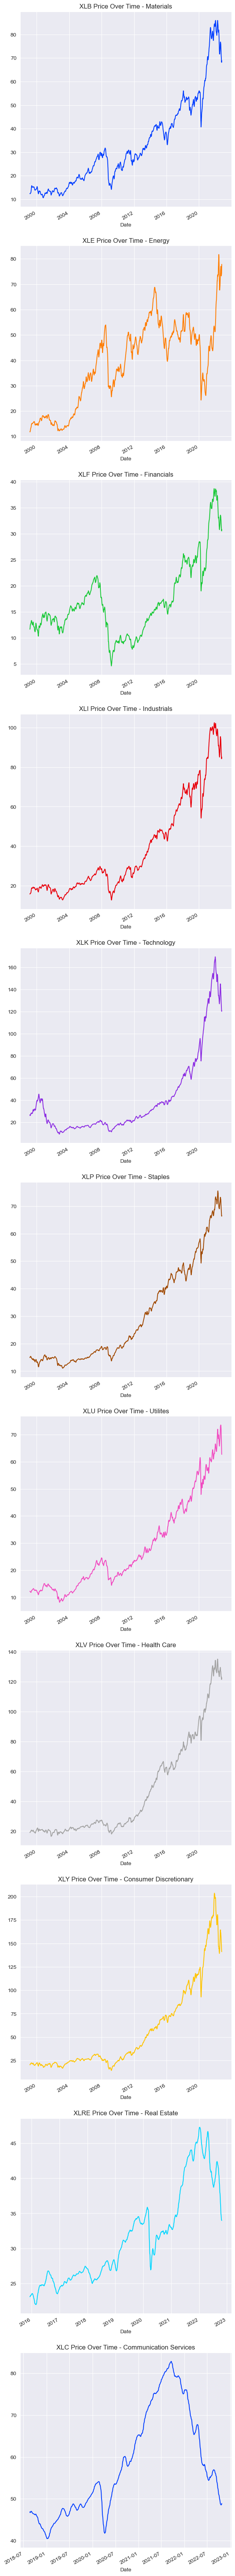

In [114]:
# Plotting price over time
sns.set_style("darkgrid")
sectors = ["Materials", "Energy", "Financials", "Industrials", "Technology", "Staples", "Utilites", "Health Care",\
          "Consumer Discretionary", "Real Estate", "Communication Services"]

palette = sns.color_palette("bright", n_colors=11)
fig, ax = plt.subplots(nrows=11, figsize=(7,96))

for num, i in enumerate(tickers):
    df[df["Ticker"]==i]["Adj Close"].rolling(window=20).mean().\
    plot(kind="line", color=palette[num], title=f"{i} Price Over Time - {sectors[num]}", ax=ax[num])

### Monthly Statistics

In [117]:
df.reset_index(inplace=True)
df.set_index(["Date", "Ticker"], inplace=True)

##### Keep in mind that XLC and XLRE do not have as much data, and so their performance might be noisy

In [118]:
# XLE has highest average monthly stock gain not accounting for dividends/expenses

# Creates multi-index columns, then re-structures the df by Monthly groups
monthly_data = df.unstack("Ticker").resample('M')

# Subtract the price at month's end from the price and month's start divided by price at month's start * 100 for %
monthly_percentage_change = monthly_data['Adj Close'].transform(lambda x: (x.iloc[-1] - x.iloc[0]) / x.iloc[0] * 100)

# Sort the last of mean percentage monthly gains
monthly_percentage_change.mean().sort_values(ascending=False)

Ticker
XLE     0.719806
XLI     0.715088
XLRE    0.683641
XLY     0.674212
XLV     0.659087
XLB     0.628262
XLU     0.587437
XLK     0.547366
XLF     0.471629
XLP     0.452161
XLC     0.094741
dtype: float64

In [119]:
# Fuller Picture of monthly returns

monthly_percentage_change.describe()

Ticker,XLB,XLC,XLE,XLF,XLI,XLK,XLP,XLRE,XLU,XLV,XLY
count,5975.000000,1067.000000,5975.000000,5975.000000,5975.000000,5975.000000,5975.000000,1738.000000,5975.000000,5975.000000,5975.000000
mean,0.628262,0.094741,0.719806,0.471629,0.715088,0.547366,0.452161,0.683641,0.587437,0.659087,0.674212
std,6.065142,6.467678,7.278915,6.439148,5.422227,6.610238,3.559081,5.220937,4.369821,4.166507,5.682687
min,-21.095915,-15.528095,-36.920879,-27.014192,-21.390413,-24.865885,-13.237411,-19.129234,-14.998888,-14.104289,-17.739845
25%,-2.556944,-5.458970,-2.830217,-2.496501,-2.193276,-2.972382,-1.581248,-1.478468,-1.758879,-1.582004,-2.307308
50%,0.636818,1.158390,0.392216,0.657136,0.853207,1.068237,0.862412,0.846156,1.023536,0.643068,0.884793
75%,3.849910,3.705945,4.894552,3.906772,3.778352,4.274348,2.709542,3.900496,3.271118,2.853546,3.774150
max,23.590361,18.361571,37.581468,24.977050,17.676029,26.440601,10.991583,16.483496,11.876575,17.040225,24.439696


### Yearly statistics - taken from year start - year end, averages of each, so can be misleading

In [120]:
# XLC has highest average yearly stock gain not accounting for dividends/expenses

yearly_data = df.unstack("Ticker").resample('Y')
yearly_percentage_change = yearly_data['Adj Close'].transform(lambda x: (x.iloc[-1] - x.iloc[0]) / x.iloc[0] * 100)
yearly_percentage_change.mean().sort_values(ascending=False)

Ticker
XLC     11.921543
XLE     10.651872
XLRE    10.627250
XLY     10.190422
XLK      9.713185
XLB      9.539807
XLI      9.243045
XLV      9.016944
XLU      8.744014
XLP      7.635755
XLF      6.713711
dtype: float64

In [121]:
# Fuller picture of stock appreciation

yearly_percentage_change.describe()

Ticker,XLB,XLC,XLE,XLF,XLI,XLK,XLP,XLRE,XLU,XLV,XLY
count,5975.000000,962.000000,5975.000000,5975.000000,5975.000000,5975.000000,5975.000000,1716.000000,5975.000000,5975.000000,5975.000000
mean,9.539807,11.921543,10.651872,6.713711,9.243045,9.713185,7.635755,10.627250,8.744014,9.016944,10.190422
std,19.633891,23.908520,25.961128,21.406949,17.849276,26.748360,12.547828,23.061193,15.996774,12.786017,19.542435
min,-43.506963,-33.255291,-39.070507,-53.995783,-37.693424,-43.517478,-19.809941,-28.209040,-29.777610,-22.497939,-31.930355
25%,-6.030355,17.706276,-14.037703,-6.814668,-1.803619,0.540779,2.841797,-1.821364,1.786397,1.534570,0.061182
50%,15.914757,25.430945,12.714313,11.017481,12.762142,13.688117,10.991900,5.197603,12.325627,7.664282,13.662277
75%,22.910308,29.324796,26.888772,25.142452,23.246328,32.318574,13.931282,31.700130,20.746765,17.136342,27.424322
max,42.940711,29.324796,57.688412,36.652029,37.253084,49.759204,28.191247,50.973780,30.744411,38.662447,39.814892


While some of these sector ETFs move in concert, there is clearly observable performance dislocation between other ETFs. Also, certain sectors spiders pay dividends. A dividend is a payout of a company's earnings given directly to its shareholders, and dividends are generally described as the percentage of the current asset price to be paid out annually. For individual assets dividend rates and schedules can change depending on performance, however when dealing with a basket of stocks, like those within an ETF, dividends and their structures are usually more reliably consistent. Each of these ETFs also has an associated expense ratio, or amount taken out of your investment to fund the operations of the ETF.
### Dividends of ETFs
- XLB 2.11%
- XLE 3.50%
- XLF 2.00%
- XLI 1.83%
- XLK 0.97%
- XLP 2.81%
- XLU 3.71%
- XLV 1.77%
- XLY 0.87%
- XLRE 3.99%
- XLC 1.06%

### Expense Ratios
Each of the sector spiders has a 0.1% expense ratio. That means that if your investment in a given spider was $1,000 at the start of the year, you would expect to pay an expense of 0.1% on that amount, or 1 dollar. 

<hr style="border: 2px solid green">

# Model Prep
Now that we have performed some superficial inspection of these ETFs, we can begin model iterations. 

### Splitting Data in Prep for Models

In [128]:
df.reset_index(inplace=True)
df.set_index("Date", inplace=True)

In [129]:
# DFs for each index

# Materials
materials_df = df[df["Ticker"]== "XLB"]

# Energy
energy_df = df[df["Ticker"]== "XLE"]

# Financials
financial_df = df[df["Ticker"]== "XLF"]

# Industrials
industrial_df = df[df["Ticker"]== "XLI"]

# Technology
tech_df = df[df["Ticker"]== "XLK"]

# Staples
staples_df = df[df["Ticker"]== "XLP"]

# Utilities
utilities_df = df[df["Ticker"]== "XLU"]

# Health Care
health_df = df[df["Ticker"]== "XLV"]

# Consumer Discretionary
consumer_df = df[df["Ticker"]== "XLY"]

# Real Estate
real_df = df[df["Ticker"]== "XLRE"]

# Tele-com / communication services
communication_df = df[df["Ticker"]== "XLC"]

In [130]:
# Definition to handle splits using df, and string for time horizon

def select_data(df, time_horizon:str):
    
    X = df.drop(columns=["Ticker", 'one_months_later', 'three_months_later', 'six_months_later', \
                         'twelve_months_later', 'One_Month_Positive', 'Three_Month_Positive', 'Six_Month_Positive',\
                         'Twelve_Month_Positive'])
    y = df[f'{time_horizon.title()}_Month_Positive']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=131)
    return X_train, X_test, y_train, y_test

<hr style="border: 4px solid green">

# Dummy Model

In [131]:
# Preparing for our first batch of models, we will proceed index by index and from time horizons low to high

X_train, X_test, y_train, y_test = select_data(materials_df, "One")

dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
dummy1 = Model("Dummy Model", dummy, X_train, X_test, y_train, y_test)
Model.model_df

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.8s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
0,Dummy Model,0.602544,0.602544,1.0,0.751984,14.325759,0.60241,0.60241,1.0,0.75188,14.330609,0.5


# Pipelines

In [132]:
# Sub-pipe for numeric transformation
num_pipe = Pipeline(steps=[
    ("ss", StandardScaler())
])

# Sub-pipe for categorical transformation
cat_pipe = Pipeline(steps=[
    ("ohe", OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Column Transformer object to be given to the ultimate pipeline model
ct = ColumnTransformer(transformers=[
    ("num_pipe", num_pipe, selector(dtype_include=np.number)),
    ('cat_pipe', cat_pipe, selector(dtype_include=object))
])

In [147]:
# Pipeline for model fitting and commented out models that will be fit 



                        # Model types/hyperparameters
    
    # LogisticRegression(n_jobs=4, verbose=0, random_state=13, solver='lbfgs', max_iter=100, C=1, tol=0.0001, \
    # fit_intercept=True)
    
    
    # KNeighborsClassifier(n_neighbors=5, weights='uniform',algorithm='auto', leaf_size=30, p=2, \
#                                 metric='minkowski', metric_params=None, n_jobs=4)
    
#     RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2,\
#                                   min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features="sqrt",\
#                                   max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True,\
#                                   oob_score=False, n_jobs=4, random_state=13, verbose=0, class_weight=None)
    
#     ExtraTreesClassifier(n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1, \
#     min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, \
#     bootstrap=False,oob_score=False, n_jobs=None, random_state=13, verbose=0, warm_start=False, class_weight=None, \
#     ccp_alpha=0.0, max_samples=None,)

    # AdaBoostClassifier(estimator=None, n_estimators=50,learning_rate=1.0, algorithm='SAMME.R',\
#                               random_state=13, base_estimator='deprecated')

#     XGBClassifier(n_estimators=50, max_depth=None, max_leaves=0, learning_rate=1.0, booster='gbtree',\
#                          tree_method="auto", n_jobs=4, random_state=13)


                                # Normal Protocol

# model_pipe = Pipeline(steps=[
#     ("ct", ct),
#     ("model", XGBClassifier(n_estimators=50, max_depth=None, max_leaves=0, learning_rate=1.0, booster='gbtree',\
#                          tree_method="auto", n_jobs=4, random_state=13)  
     
#     )])

# model_pipe.fit(X_train, y_train)

                      
                                # Special protocol for multi ensemble models
        
        
    # VotingClassifier(estimators=[
#         ('et', etc.model),
#         ('rf', rfc.model),
#         ('xg', XGBoost.model)
#     ], voting='soft', weights=None, n_jobs=4, flatten_transform=True, verbose=False,)

ct.fit(X_train)
transformed_X_train = pd.DataFrame(ct.transform(X_train), index=X_train.index, columns=ct.get_feature_names_out())
transformed_X_test = pd.DataFrame(ct.transform(X_test), index=X_test.index, columns=ct.get_feature_names_out())

model_pipe = Pipeline(steps=[
    ("model", VotingClassifier(estimators=[
        ('et', etc.model),
        ('rf', rfc.model),
        ('xg', XGBoost.model)
    ], voting='soft', weights=None, n_jobs=4, flatten_transform=True, verbose=False,)
)])
     
model_pipe.fit(transformed_X_train, y_train)

Pipeline(steps=[('model',
                 VotingClassifier(estimators=[('et',
                                               Pipeline(steps=[('ct',
                                                                ColumnTransformer(transformers=[('num_pipe',
                                                                                                 Pipeline(steps=[('ss',
                                                                                                                  StandardScaler())]),
                                                                                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fc0d2a096c0>),
                                                                                                ('cat_pipe',
                                                                                                 Pipeline(steps=[('ohe',
                                                                                                                  OneHotEncoder(handle_unknown='ignore',
                                                                                                                                sparse_output=False))]),
                                                                                                 <sk...
                                                                              importance_type=None,
                                                                              interaction_constraints=None,
                                                                              learning_rate=1.0,
                                                                              max_bin=None,
                                                                              max_cat_threshold=None,
                                                                              max_cat_to_onehot=None,
                                                                              max_delta_step=None,
                                                                              max_depth=None,
                                                                              max_leaves=0,
                                                                              min_child_weight=None,
                                                                              missing=nan,
                                                                              monotone_constraints=None,
                                                                              n_estimators=50,
                                                                              n_jobs=4,
                                                                              num_parallel_tree=None,
                                                                              predictor=None,
                                                                              random_state=13, ...))]))],
                                  n_jobs=4, voting='soft'))])

In [149]:
# logreg = Model("Materials Logistic Regression 1-Month", model_pipe, X_train, X_test, y_train, y_test)
# knn = Model("Materials KNN 1-Month", model_pipe, X_train, X_test, y_train, y_test)
# rfc = Model("Materials RFC 1-Month", model_pipe, X_train, X_test, y_train, y_test)
# etc = Model("Materials ExtraTrees 1-Month", model_pipe, X_train, X_test, y_train, y_test)
# adaboost = Model("Materials AdaBoost 1-Month", model_pipe, X_train, X_test, y_train, y_test)
# XGBoost = Model("Materials XGBoost 1-Month", model_pipe, X_train, X_test, y_train, y_test)
# votingC = Model("Materials Voting Ensemble 1-Month", model_pipe, transformed_X_train, transformed_X_test, y_train, y_test)

Model.model_df.sort_values(by="test_accuracy", ascending=False)

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
4,Materials ExtraTrees 1-Month,0.893550,0.904020,0.921111,0.912466,0.280764,0.919009,0.928493,0.937778,0.933112,0.225883,0.975179
3,Materials RFC 1-Month,0.873911,0.877710,0.918889,0.897803,0.336598,0.906961,0.916758,0.930000,0.923331,0.289981,0.960551
7,Materials Voting Ensemble 1-Month,0.875027,0.877864,0.920741,0.898771,0.304150,0.898929,0.911087,0.922222,0.916621,0.257379,0.964611
6,Materials XGBoost 1-Month,0.831955,0.845514,0.882593,0.863552,0.454065,0.854083,0.878049,0.880000,0.879023,0.381968,0.924848
2,Materials KNN 1-Month,0.736218,0.769240,0.803333,0.785856,1.523782,0.730254,0.770403,0.786667,0.778450,1.257594,0.790194
5,Materials AdaBoost 1-Month,0.684667,0.695814,0.847778,0.764184,0.686865,0.688086,0.696915,0.853333,0.767233,0.684471,0.759944
1,Materials Logistic Regression 1-Month,0.631548,0.648627,0.847407,0.734707,0.643622,0.621151,0.644464,0.827778,0.724708,0.638358,0.654961
0,Dummy Model,0.602544,0.602544,1.000000,0.751984,14.325759,0.602410,0.602410,1.000000,0.751880,14.330609,0.500000


- Logistic Regression, max iter warning that more iterations are likely required, slight improvement over the dummy baseline
- KNN performed MUCH better than baseline logistic regression
- RFC once again is a major improvement on the previous two models
- Extra Trees is a slight improvement over RandomForest, better on every metric of test set
- AdaBoost performs significantly worse than KNN, better than Logistic Regression
- XGBoost once again is slotting in below the Forest Ensembles, RFC and ETC, but still strong performance
- Voting Ensemble composed of the top 3 models performed worse than ExtraTrees and RFC respectively

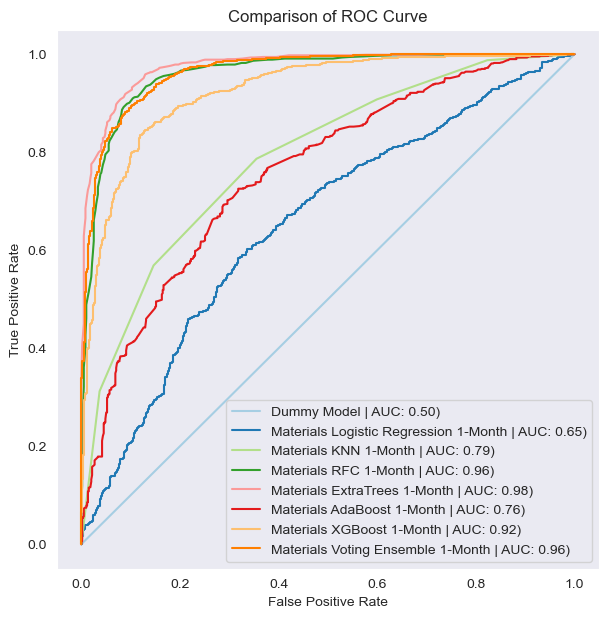

In [150]:
logreg.compare_roc_curve()

### GridSearch CV
Because we are not overfitting, we are really just searching for hyperparameters that can help improve the accuracy of our model. We will search through the parameters and endeavor to improve upon our model's performance. 

In [164]:
# Parameters to search through

params = {"model__criterion": ['gini', 'entropy', 'log_loss'],
         'model__max_depth': [None, 7, 5],
         'model__max_features': ["auto", "sqrt", "log2"],
         "model__ccp_alpha": [0, .001, .01, .1],
         }

In [165]:
# Fitting the gridsearch model 

grid = GridSearchCV(estimator=etc.model, param_grid=params, n_jobs=6, verbose=1)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('num_pipe',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fc0d2a096c0>),
                                                                        ('cat_pipe',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fc0d2a082b0>)])),
                                       ('model',
                                        ExtraTreesClassifier(random_state=13))]),
             n_jobs=6,
             param_grid={'model__ccp_alpha': [0, 0.001, 0.01, 0.1],
                         'model__criterion': ['gini', 'entropy', 'log_loss'],
                         'model__max_depth': [None, 7, 5],
                         'model__max_features': ['auto', 'sqrt', 'log2']},
             verbose=1)

In [166]:
grid.best_params_

{'model__ccp_alpha': 0,
 'model__criterion': 'entropy',
 'model__max_depth': None,
 'model__max_features': 'sqrt'}

In [159]:
# Best hyperparameters 

grid.best_params_

{'model__ccp_alpha': 0.001,
 'model__criterion': 'entropy',
 'model__max_depth': None,
 'model__max_features': 'sqrt'}

### Gridsearch Best Params
- ccp_alpha = 0 default and chosen
- criterion: entropy chosen instead of Default "gini"
- max_depth: None is the default and was chosen
- max_features: "sqrt" was the default

### Only change was from gini to entropy

In [167]:
# Adding GridSearchCV searched model

# gridS_cv = Model("GridSearched ETC, 1-Month XLB", grid.best_estimator_, X_train, X_test, y_train, y_test)
# gridS_cv_redo = Model("GridSearched ETC Redo, 1-Month XLB", grid.best_estimator_, X_train, X_test, y_train, y_test)
Model.model_df.sort_values(by="test_accuracy", ascending=False)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.6s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
9,"GridSearched ETC Redo, 1-Month XLB",0.896675,0.906934,0.923333,0.915036,0.300330,0.921017,0.932522,0.936667,0.934590,0.221965,0.976621
4,Materials ExtraTrees 1-Month,0.893550,0.904020,0.921111,0.912466,0.280764,0.919009,0.928493,0.937778,0.933112,0.225883,0.975179
3,Materials RFC 1-Month,0.873911,0.877710,0.918889,0.897803,0.336598,0.906961,0.916758,0.930000,0.923331,0.289981,0.960551
7,Materials Voting Ensemble 1-Month,0.875027,0.877864,0.920741,0.898771,0.304150,0.898929,0.911087,0.922222,0.916621,0.257379,0.964611
8,"GridSearched ETC, 1-Month XLB",0.870340,0.874018,0.917037,0.894989,0.356730,0.872825,0.873684,0.922222,0.897297,0.347284,0.945513
6,Materials XGBoost 1-Month,0.831955,0.845514,0.882593,0.863552,0.454065,0.854083,0.878049,0.880000,0.879023,0.381968,0.924848
2,Materials KNN 1-Month,0.736218,0.769240,0.803333,0.785856,1.523782,0.730254,0.770403,0.786667,0.778450,1.257594,0.790194
5,Materials AdaBoost 1-Month,0.684667,0.695814,0.847778,0.764184,0.686865,0.688086,0.696915,0.853333,0.767233,0.684471,0.759944
1,Materials Logistic Regression 1-Month,0.631548,0.648627,0.847407,0.734707,0.643622,0.621151,0.644464,0.827778,0.724708,0.638358,0.654961
0,Dummy Model,0.602544,0.602544,1.000000,0.751984,14.325759,0.602410,0.602410,1.000000,0.751880,14.330609,0.500000


### Final Observations
The difference of 0.001 in ccp_alpha allowed for an improvement on our best model of 0.2% total but NEARLY 5% OVERALL between different GridSearchCV best_estimators_. I find these results fascinating, and they also serve as a reminder than very minute changes can result in outsized changes in performance.

In [214]:
# Extracting feature importances and adding them to a dataframe to contain them for each model

features = list(gridS_cv_redo.model.get_params()["ct"].get_feature_names_out())
features_list = [i.replace("num_pipe__", "").replace("cat_pipe__","") for i in features]
len(features_list)

imp_feats = gridS_cv_redo.model.get_params()['model'].feature_importances_

imp_list = list(zip(features_list, imp_feats))
imp_dict = dict(imp_list)

# Importance(x)
# Importance.df.rename(index={0:"1 Month XLB"}, inplace=True)

print("Top 5 Feature Importances")
for i in sorted(imp_list, key=lambda x: x[1], reverse=True)[:5]:
    print(i)
Importance.df

Top 5 Feature Importances
('20_day_SMA', 0.05458984040859659)
('MACD', 0.05336703725587483)
('lower_bollinger_band', 0.053166315213548525)
('lowest_bollinger_band', 0.05298822022809901)
('ATR', 0.052782983016137576)


,Interest Rates,GDP,ATR,lowest_bollinger_band,MACD,lower_bollinger_band,upper_bollinger_band,20_day_SMA,one_up_bollinger_band,Close,High,Adj Close,Low,RSI,Open,dollar_volume(M),Volume,garman_klass_vol,SMB,CMA,HML,RMW,Mkt-RF,Quarter_1,Quarter_2,Quarter_3,Quarter_4,cycle_year_1,cycle_year_2,cycle_year_3,cycle_year_4
1 Month XLB,0.052312,0.026385,0.052783,0.052988,0.053367,0.053166,0.050207,0.05459,0.051651,0.049915,0.046586,0.048623,0.047186,0.044443,0.041953,0.024971,0.024999,0.029226,0.018022,0.01818,0.018712,0.018992,0.017569,0.014466,0.01395,0.012738,0.01292,0.01084,0.01112,0.015179,0.011959


In [ ]:
sorted(list(zip(list(X_train.columns), ET1.model.get_params()['lr'].feature_importances_)),\
       key= lambda x: x[1], reverse=True)


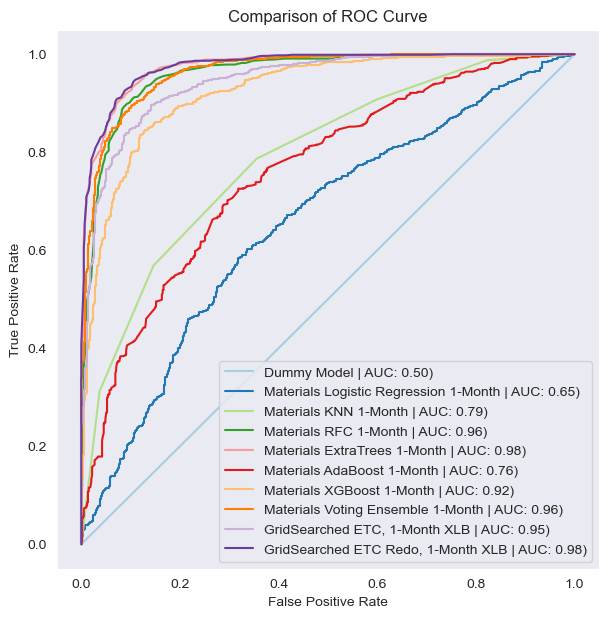

In [169]:
gridS_cv_redo.compare_roc_curve()

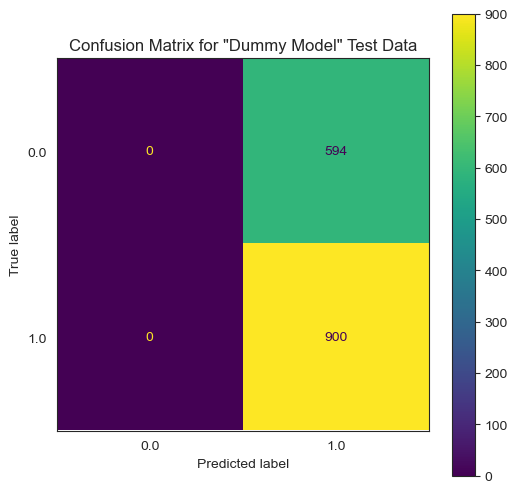

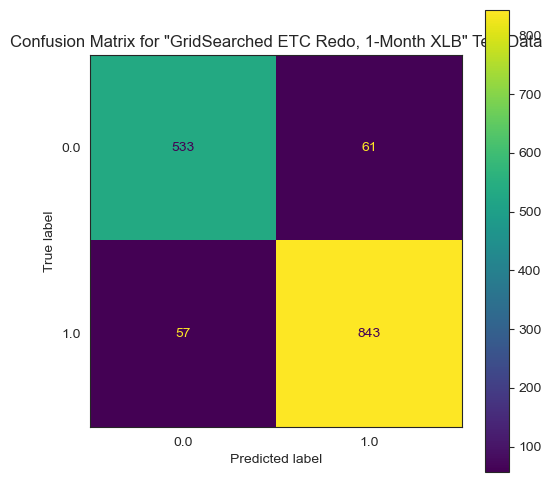

In [176]:
# Plotting best model compared to the dummy

best_models_and_dummy = [dummy1, gridS_cv_redo]
for i in best_models_and_dummy:
    i.confusion_matrix();

<hr style="border: 2px solid royalblue">

In [221]:
sectors = ["Materials", "Energy", "Financials", "Industrials", "Technology", "Staples", "Utilites", "Health Care",\
          "Consumer Discretionary", "Real Estate", "Communication Services"]

In [252]:
from spider_classes import Materials, Energy, Financials, Industrials, Technology, Staples, Utilities, Health, \
Consumer, Real_Estate, Communication_Services

# Loop to model the data

In [245]:
# Iterations
X_train, X_test, y_train, y_test = select_data(materials_df, "Three")

dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)

# CHANGE THE CLASS EACH TIME
dummy1 = Model("Dummy Materials 3-Month", dummy, X_train, X_test, y_train, y_test)

# Sub-pipe for numeric transformation
num_pipe = Pipeline(steps=[
("ss", StandardScaler())
])

# Sub-pipe for categorical transformation
cat_pipe = Pipeline(steps=[
    ("ohe", OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Column Transformer object to be given to the ultimate pipeline model
ct = ColumnTransformer(transformers=[
    ("num_pipe", num_pipe, selector(dtype_include=np.number)),
    ('cat_pipe', cat_pipe, selector(dtype_include=object))
])


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.1s finished


In [249]:
# Final Pipe

# All the baseline algorithms I am using 

# LogisticRegression(n_jobs=4, verbose=0, random_state=13, solver='lbfgs', max_iter=100, C=1, tol=0.0001, \
# fit_intercept=True), \

# KNeighborsClassifier(n_neighbors=5, weights='uniform',algorithm='auto', leaf_size=30, p=2, \
#                                 metric='minkowski', metric_params=None, n_jobs=4)

# RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2,\
#                                   min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features="sqrt",\
#                                   max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True,\
#                                   oob_score=False, n_jobs=4, random_state=13, verbose=0, class_weight=None)

# ExtraTreesClassifier(n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1, \
#     min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, \
#     bootstrap=False,oob_score=False, n_jobs=None, random_state=13, verbose=0, warm_start=False, class_weight=None, \
#     ccp_alpha=0.0, max_samples=None)
 

    #     AdaBoostClassifier(estimator=None, n_estimators=50,learning_rate=1.0, algorithm='SAMME.R',\
#                               random_state=13, base_estimator='deprecated')

#     XGBClassifier(n_estimators=50, max_depth=None, max_leaves=0, learning_rate=1.0, booster='gbtree'
#                          tree_method="auto", n_jobs=4, random_state=13)



model_pipe = Pipeline(steps=[
    ("ct", ct),
    ("model", RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2,\
                                  min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features="sqrt",\
                                  max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True,\
                                  oob_score=False, n_jobs=4, random_state=13, verbose=0, class_weight=None)
    
    )])

model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc0c3a947f0>),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc0c3a94b80>)])),
                ('model', RandomForestClassifier(n_jobs=4, random_state=13))])

In [250]:
# logreg1 = Model("Materials Logistic Regression 3-Month", model_pipe, X_train, X_test, y_train, y_test)
# knn1 = Model("Materials KNN 3-Month", model_pipe, X_train, X_test, y_train, y_test)
# rfc1 = Model("Materials RFC 3-Month", model_pipe, X_train, X_test, y_train, y_test)
# etc1 = Model("Materials ExtraTrees 3-Month", model_pipe, X_train, X_test, y_train, y_test)
# adaboost1 = Model("Materials AdaBoost 3-Month", model_pipe, X_train, X_test, y_train, y_test)
# XGBoost1 = Model("Materials XGBoost 3-Month", model_pipe, X_train, X_test, y_train, y_test)
# votingC1 = Model("Materials Voting Ensemble 3-Month", model_pipe, transformed_X_train, transformed_X_test, y_train, y_test)

Model.model_df

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.9s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
0,Dummy Model,0.602544,0.602544,1.000000,0.751984,14.325759,0.602410,0.602410,1.000000,0.751880,14.330609,0.500000
1,Materials Logistic Regression 1-Month,0.631548,0.648627,0.847407,0.734707,0.643622,0.621151,0.644464,0.827778,0.724708,0.638358,0.654961
2,Materials KNN 1-Month,0.736218,0.769240,0.803333,0.785856,1.523782,0.730254,0.770403,0.786667,0.778450,1.257594,0.790194
3,Materials RFC 1-Month,0.873911,0.877710,0.918889,0.897803,0.336598,0.906961,0.916758,0.930000,0.923331,0.289981,0.960551
4,Materials ExtraTrees 1-Month,0.893550,0.904020,0.921111,0.912466,0.280764,0.919009,0.928493,0.937778,0.933112,0.225883,0.975179
5,Materials AdaBoost 1-Month,0.684667,0.695814,0.847778,0.764184,0.686865,0.688086,0.696915,0.853333,0.767233,0.684471,0.759944
6,Materials XGBoost 1-Month,0.831955,0.845514,0.882593,0.863552,0.454065,0.854083,0.878049,0.880000,0.879023,0.381968,0.924848
7,Materials Voting Ensemble 1-Month,0.875027,0.877864,0.920741,0.898771,0.304150,0.898929,0.911087,0.922222,0.916621,0.257379,0.964611
8,"GridSearched ETC, 1-Month XLB",0.870340,0.874018,0.917037,0.894989,0.356730,0.872825,0.873684,0.922222,0.897297,0.347284,0.945513
9,"GridSearched ETC Redo, 1-Month XLB",0.896675,0.906934,0.923333,0.915036,0.300330,0.921017,0.932522,0.936667,0.934590,0.221965,0.976621


In [60]:
import pickle 

with open('pickle_test.pkl', 'wb') as file:
    pickle.dump(Model.model_list, file)

In [67]:
len(Model.model_list)

8

In [62]:
for i in Model.model_list:
    print(i)

Model name: Dummy Model
Model name: Materials Logistic Regression
Model name: Materials KNN 1-Month
Model name: Materials RFC 1-Month
Model name: Materials ExtraTrees 1-Month
Model name: Materials AdaBoost 1-Month
Model name: Materials XGBoost 1-Month
Model name: Materials Voting Ensemble 1-Month
